### Here I'll show how you can build multiple models, ensemble but also evaluate each of them, this may help instead of just train random models and then blindly submit the results.

#### This is another iteration of the amazing work of Chris Deotte [checkout here](https://www.kaggle.com/cdeotte/support-vector-machine-0-925)

# Dependencies

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC, NuSVC
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score

%matplotlib inline
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

# Load data

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

print('Train set shape:', train.shape)
print('Test set shape:', test.shape)
print('Train set overview:')
display(train.head())

Train set shape: (262144, 258)
Test set shape: (131073, 257)
Train set overview:


,id,muggy-smalt-axolotl-pembus,dorky-peach-sheepdog-ordinal,slimy-seashell-cassowary-goose,snazzy-harlequin-chicken-distraction,frumpy-smalt-mau-ordinal,stealthy-beige-pinscher-golden,chummy-cream-tarantula-entropy,hazy-emerald-cuttlefish-unsorted,nerdy-indigo-wolfhound-sorted,leaky-amaranth-lizard-sorted,ugly-tangerine-chihuahua-important,shaggy-silver-indri-fimbus,flaky-chocolate-beetle-grandmaster,squirrely-harlequin-sheep-sumble,freaky-tan-angelfish-noise,lousy-plum-penguin-sumble,bluesy-rose-wallaby-discard,baggy-copper-oriole-dummy,stealthy-scarlet-hound-fepid,greasy-cinnamon-bonobo-contributor,cranky-cardinal-dogfish-ordinal,snippy-auburn-vole-learn,greasy-sepia-coral-dataset,flabby-tangerine-fowl-entropy,lousy-smalt-pinscher-dummy,bluesy-brass-chihuahua-distraction,goopy-eggplant-indri-entropy,homey-sepia-bombay-sorted,homely-ruby-bulldog-entropy,hasty-blue-sheep-contributor,blurry-wisteria-oyster-master,snoopy-auburn-dogfish-expert,stinky-maroon-blue-kernel,bumpy-amaranth-armadillo-important,slaphappy-peach-oyster-master,dorky-tomato-ragdoll-dataset,messy-mauve-wolverine-ordinal,geeky-pumpkin-moorhen-important,crabby-teal-otter-unsorted,...,beady-mauve-frog-distraction,surly-brass-maltese-ordinal,beady-asparagus-opossum-expert,beady-rust-impala-dummy,droopy-amethyst-dachshund-hint,homey-crimson-budgerigar-grandmaster,droopy-cardinal-impala-important,woozy-apricot-moose-hint,paltry-sapphire-labradoodle-dummy,crappy-carmine-eagle-entropy,greasy-magnolia-spider-grandmaster,crabby-carmine-flounder-sorted,skimpy-copper-fowl-grandmaster,hasty-seashell-woodpecker-hint,snappy-purple-bobcat-important,thirsty-carmine-corgi-ordinal,homely-auburn-reindeer-unsorted,crappy-beige-tiger-fepid,cranky-auburn-swan-novice,chewy-bistre-buzzard-expert,skinny-cyan-macaque-pembus,slimy-periwinkle-otter-expert,snazzy-burgundy-clam-novice,cozy-ochre-gorilla-gaussian,homey-sangria-wolfhound-dummy,snazzy-asparagus-hippopotamus-contributor,paltry-red-hamster-sorted,zippy-dandelion-insect-golden,baggy-coral-bandicoot-unsorted,goopy-lavender-wolverine-fimbus,wheezy-myrtle-mandrill-entropy,wiggy-lilac-lemming-sorted,gloppy-cerise-snail-contributor,woozy-silver-havanese-gaussian,jumpy-thistle-discus-sorted,muggy-turquoise-donkey-important,blurry-buff-hyena-entropy,bluesy-chocolate-kudu-fepid,gamy-white-monster-expert,target
0,707b395ecdcbb4dc2eabea00e4d1b179,-2.070654,1.018160,0.228643,0.857221,0.052271,0.230303,-6.385090,0.439369,-0.721946,-0.227027,0.575964,1.541908,1.745286,-0.624271,3.600958,1.176489,-0.182776,-0.228391,1.682263,-0.833236,-4.377688,-5.372410,-0.477742,-0.179005,-0.516475,0.127391,-0.857591,-0.461500,2.160303,-2.118371,0.515493,-1.201493,-0.027377,-1.154024,0.753204,-0.179651,-0.807341,-1.663626,0.893806,...,-1.829848,2.347131,0.082462,-1.012654,0.593752,2.904654,-0.428974,-0.919979,2.849575,-0.906744,0.729459,0.386140,0.319814,-0.407682,-0.170667,-1.242919,-1.719046,-0.132395,-0.368991,-5.112553,-2.085988,-0.897257,1.080671,-0.273262,0.342824,0.640177,-0.415298,-0.483126,-0.080799,2.416224,0.351895,0.618824,-1.542423,0.598175,0.611757,0.678772,0.247059,-0.806677,-0.193649,0
1,5880c03c6582a7b42248668e56b4bdec,-0.491702,0.082645,-0.011193,1.071266,-0.346347,-0.082209,0.110579,-0.382374,-0.229620,0.783980,-1.280579,-1.003480,-7.753201,-1.320547,0.919078,-1.036068,0.030213,0.910172,-0.905345,0.646641,-0.465291,-0.531735,-0.756781,0.193724,0.224277,-0.474412,1.885805,0.205439,-6.481422,1.035620,-0.453623,0.375936,-0.320670,-0.144646,-0.220129,0.577826,-0.360512,-0.600107,0.008111,...,0.982205,-1.161978,0.532269,1.133215,0.003503,-1.390962,0.158572,0.143794,-0.317185,1.017192,-0.395342,-0.642357,-0.627209,0.257271,-1.461564,0.325613,1.628369,0.640040,0.750735,1.164573,0.900373,0.063489,0.948158,0.273014,-1.269147,-0.251101,-2.271731,-0.044167,-0.443766,-1.144794,-0.645115,-1.246090,2.613357,-0.479664,1.581289,0.931258,0.151937,-0.766595,0.474351,0
2,4ccbcb3d13e5072ff1d9c61afe2c4f77,-1.680473,0.860529,-1.076195,0.740124,3.678445,0.28855

# Model

## Model parameters

In [3]:
N_FOLDS = 5

### You can find evaluation metrics for each model on each fold below on this cell output log. (It's hidden to keep the code clean)

In [4]:
# INITIALIZE VARIABLES
cols = [c for c in train.columns if c not in ['id', 'target', 'wheezy-copper-turtle-magic', 'preds']]
test['target_knn'] = 0
train['preds_knn'] = 0
test['target_mlp'] = 0
train['preds_mlp'] = 0
test['target_svc'] = 0
train['preds_svc'] = 0
test['target_nusvc'] = 0
train['preds_nusvc'] = 0
test['target_qda'] = 0
train['preds_qda'] = 0

# BUILD 512 MODELS
for i in range(512):
    print('wheezy-copper-turtle-magic {}\n'.format(i))
    
    # EXTRACT SUBSET OF DATASET WHERE WHEEZY-MAGIC EQUALS I
    train2 = train[train['wheezy-copper-turtle-magic']==i]
    test2 = test[test['wheezy-copper-turtle-magic']==i]
    idx1 = train2.index
    idx2 = test2.index
    train2.reset_index(drop=True, inplace=True)
    
    data = pd.concat([pd.DataFrame(train2[cols]), pd.DataFrame(test2[cols])])
    data2 = StandardScaler().fit_transform(PCA(svd_solver='full',n_components='mle').fit_transform(data[cols]))
    train3 = data2[:train2.shape[0]]
    test3 = data2[train2.shape[0]:]

    skf = StratifiedKFold(n_splits=N_FOLDS, random_state=0)
    counter = 0

    for train_index, val_index in skf.split(train3, train2['target']):
        counter += 1
        print('Fold {}\n'.format(counter))
        model_names = ['knn', 'mlp', 'svc', 'nusvc', 'qda']
        models = [KNeighborsClassifier(n_neighbors=17, p=2.9), 
                  MLPClassifier(random_state=3, activation='relu', solver='lbfgs', tol=1e-06, hidden_layer_sizes=(250, )), 
                  SVC(probability=True, kernel='poly', degree=4, gamma='auto', random_state=42), 
                  NuSVC(probability=True, kernel='poly', degree=4, gamma='auto', random_state=4, nu=0.59, coef0=0.053), 
                  QuadraticDiscriminantAnalysis(0.1)]
        
        for i in range(len(model_names)):
            model = models[i]
            model_name = model_names[i]
            model.fit(train3[train_index,:], train2.loc[train_index]['target'])

            train_predictions = model.predict(train3[train_index,:])
            val_predictions = model.predict(train3[val_index,:])

            train_auc = roc_auc_score(train2.loc[train_index]['target'], train_predictions) * 100
            val_auc = roc_auc_score(train2.loc[val_index]['target'], val_predictions) * 100
            train_precision = precision_score(train2.loc[train_index]['target'], train_predictions) * 100
            val_precision = precision_score(train2.loc[val_index]['target'], val_predictions) * 100
            train_recall = recall_score(train2.loc[train_index]['target'], train_predictions) * 100
            val_recall = recall_score(train2.loc[val_index]['target'], val_predictions) * 100
            print('-----%s - Train----------' % model_name)
            print('AUC: %.2f Precision: %.2f Recall: %.2f \n' % (train_auc, train_precision, train_recall))
            print('-----%s - Validation-----' % model_name)
            print('AUC: %.2f Precision: %.2f Recall: %.2f \n' % (val_auc, val_precision, val_recall))

            # Make predictions
            train[('preds_%s' % model_name)].loc[idx1] += model.predict_proba(train3)[:,1] / N_FOLDS
            test[('target_%s' % model_name)].loc[idx2] += model.predict_proba(test3)[:,1] / N_FOLDS

wheezy-copper-turtle-magic 0

Fold 1

-----knn - Train----------
AUC: 87.51 Precision: 90.26 Recall: 83.81 

-----knn - Validation-----
AUC: 78.47 Precision: 87.50 Recall: 66.04 

-----mlp - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----mlp - Validation-----
AUC: 81.44 Precision: 82.35 Recall: 79.25 

-----svc - Train----------
AUC: 99.29 Precision: 100.00 Recall: 98.57 

-----svc - Validation-----
AUC: 75.57 Precision: 90.91 Recall: 56.60 

-----nusvc - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----nusvc - Validation-----
AUC: 78.37 Precision: 94.12 Recall: 60.38 

-----qda - Train----------
AUC: 97.65 Precision: 98.08 Recall: 97.14 

-----qda - Validation-----
AUC: 88.85 Precision: 90.20 Recall: 86.79 

Fold 2

-----knn - Train----------
AUC: 82.98 Precision: 90.59 Recall: 73.33 

-----knn - Validation-----
AUC: 85.92 Precision: 91.30 Recall: 79.25 

-----mlp - Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----mlp - Valida

# Ensemble models

Here you can ensemble any combination of models, and give the desired weight for each one.

In [5]:
train['preds_svcs'] = (train['preds_svc'] * 0.5) + (train['preds_nusvc'] * 0.5)
test['target_svcs'] = (test['target_svc'] * 0.5) + (test['target_nusvc'] * 0.5)

train['preds_avg'] = (train['preds_knn'] * 0.2) + (train['preds_mlp'] * 0.2) + (train['preds_svc'] * 0.2) + (train['preds_nusvc'] * 0.2) + (train['preds_qda'] * 0.2)
test['target_avg'] = (test['target_knn'] * 0.2) + (test['target_mlp'] * 0.2) + (test['target_svc'] * 0.2) + (test['target_nusvc'] * 0.2) + (test['target_qda'] * 0.2)

train['preds_avg2'] = (train['preds_knn'] * 0.2) + (train['preds_mlp'] * 0.05) + (train['preds_svc'] * 0.05) + (train['preds_nusvc'] * 0.7)
test['target_avg2'] = (test['target_knn'] * 0.2) + (test['target_mlp'] * 0.05) + (test['target_svc'] * 0.05) + (test['target_nusvc'] * 0.7)


# Model evaluation
## Confusion matrix (averaged model)

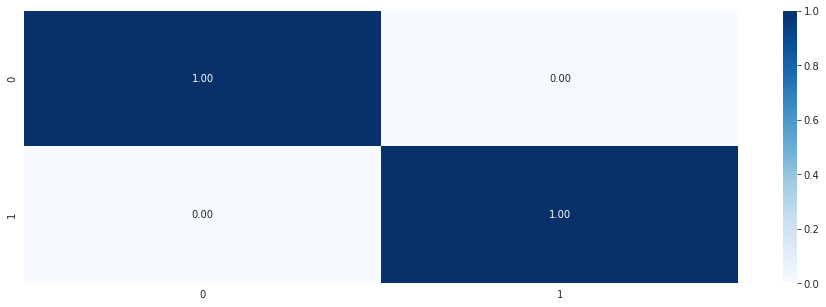

In [6]:
f = plt.subplots(1, 1, figsize=(16, 5), sharex=True)
train_cnf_matrix = confusion_matrix(train['target'], [np.round(x) for x in train['preds_avg']])
train_cnf_matrix_norm = train_cnf_matrix / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=[0, 1], columns=[0, 1])
sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

## Confusion matrix (knn model)

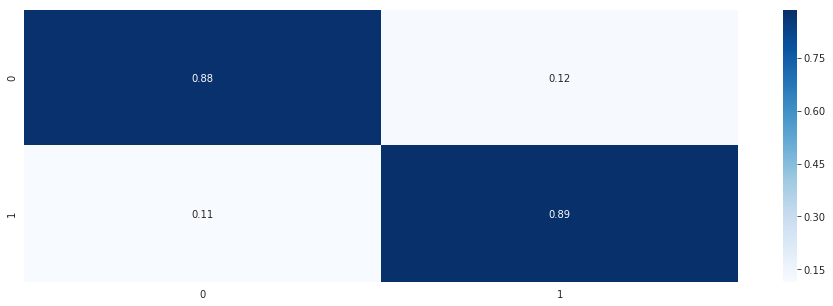

In [7]:
f = plt.subplots(1, 1, figsize=(16, 5), sharex=True)
train_cnf_matrix = confusion_matrix(train['target'], [np.round(x) for x in train['preds_knn']])
train_cnf_matrix_norm = train_cnf_matrix / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=[0, 1], columns=[0, 1])
sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

## Confusion matrix (SVC model)

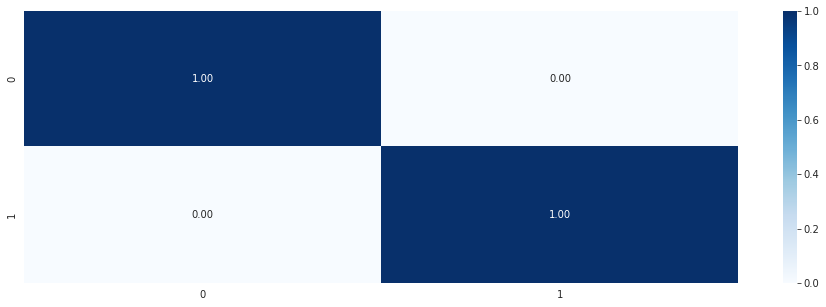

In [8]:
f = plt.subplots(1, 1, figsize=(16, 5), sharex=True)
train_cnf_matrix = confusion_matrix(train['target'], [np.round(x) for x in train['preds_svc']])
train_cnf_matrix_norm = train_cnf_matrix / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=[0, 1], columns=[0, 1])
sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

## Metrics ROC AUC

In [9]:
print('KNN AUC %.2f' % roc_auc_score(train['target'], train['preds_knn']))
print('MLP AUC %.2f' % roc_auc_score(train['target'], train['preds_mlp']))
print('SVC AUC %.2f' % roc_auc_score(train['target'], train['preds_svc']))
print('NuSVC AUC %.2f' % roc_auc_score(train['target'], train['preds_nusvc']))
print('QDA AUC %.2f' % roc_auc_score(train['target'], train['preds_qda']))
print('SVCs AUC %.2f' % roc_auc_score(train['target'], train['preds_svcs']))
print('Averaged AUC %.2f' % roc_auc_score(train['target'], train['preds_avg']))
print('Averaged 2 AUC %.2f' % roc_auc_score(train['target'], train['preds_avg2']))

KNN AUC 0.95
MLP AUC 1.00
SVC AUC 1.00
NuSVC AUC 1.00
QDA AUC 0.99
SVCs AUC 1.00
Averaged AUC 1.00
Averaged 2 AUC 1.00


### Test set with all models predictions

In [10]:
test[['id', 'target_avg', 'target_avg2', 'target_svcs', 'target_knn', 'target_mlp', 'target_svc', 'target_nusvc', 'target_qda']].head()

,id,target_avg,target_avg2,target_svcs,target_knn,target_mlp,target_svc,target_nusvc,target_qda
0,1c13f2701648e0b0d46d8a2a5a131a53,0.614571,0.637173,0.744371,0.423529,0.160618,0.765666,0.723075,0.999965
1,ba88c155ba898fc8b5099893036ef205,0.694588,0.707058,0.650716,0.635294,0.564337,0.552648,0.748785,0.971874
2,7cbab5cea99169139e7e6d8ff74ebb77,0.346801,0.269213,0.216385,0.364706,0.936526,0.236144,0.196626,0.000003
3,ca820ad57809f62eb7b4d13f5d4371a0,0.377118,0.556601,0.606916,0.470588,0.032597,0.598199,0.615634,0.168574
4,7baaf361537fbd8a1aaa2c97a6d4ccc7,0.222787,0.147462,0.188147,0.388235,0.000469,0.297870,0.078425,0.348934


# Test predictions
Now you can output predictions for each individual model and the ensembled models as well.

#### Averaged models submission

In [11]:
submission = test[['id', 'target_avg']]
submission.columns = ['id', 'target']
submission.to_csv('submission_avg.csv', index=False)
submission.head()

,id,target
0,1c13f2701648e0b0d46d8a2a5a131a53,0.614571
1,ba88c155ba898fc8b5099893036ef205,0.694588
2,7cbab5cea99169139e7e6d8ff74ebb77,0.346801
3,ca820ad57809f62eb7b4d13f5d4371a0,0.377118
4,7baaf361537fbd8a1aaa2c97a6d4ccc7,0.222787


#### Averaged 2 models submission

In [12]:
submission = test[['id', 'target_avg2']]
submission.columns = ['id', 'target']
submission.to_csv('submission_avg2.csv', index=False)
submission.head()

,id,target
0,1c13f2701648e0b0d46d8a2a5a131a53,0.637173
1,ba88c155ba898fc8b5099893036ef205,0.707058
2,7cbab5cea99169139e7e6d8ff74ebb77,0.269213
3,ca820ad57809f62eb7b4d13f5d4371a0,0.556601
4,7baaf361537fbd8a1aaa2c97a6d4ccc7,0.147462


#### SVCs models submission

In [13]:
submission = test[['id', 'target_svcs']]
submission.columns = ['id', 'target']
submission.to_csv('submission_svcs.csv', index=False)
submission.head()

,id,target
0,1c13f2701648e0b0d46d8a2a5a131a53,0.744371
1,ba88c155ba898fc8b5099893036ef205,0.650716
2,7cbab5cea99169139e7e6d8ff74ebb77,0.216385
3,ca820ad57809f62eb7b4d13f5d4371a0,0.606916
4,7baaf361537fbd8a1aaa2c97a6d4ccc7,0.188147


#### KNN model submission

In [14]:
submission = test[['id', 'target_knn']]
submission.columns = ['id', 'target']
submission.to_csv('submission_knn.csv', index=False)
submission.head()

,id,target
0,1c13f2701648e0b0d46d8a2a5a131a53,0.423529
1,ba88c155ba898fc8b5099893036ef205,0.635294
2,7cbab5cea99169139e7e6d8ff74ebb77,0.364706
3,ca820ad57809f62eb7b4d13f5d4371a0,0.470588
4,7baaf361537fbd8a1aaa2c97a6d4ccc7,0.388235


#### KNN model submission

In [15]:
submission = test[['id', 'target_mlp']]
submission.columns = ['id', 'target']
submission.to_csv('submission_mlp.csv', index=False)
submission.head()

,id,target
0,1c13f2701648e0b0d46d8a2a5a131a53,0.160618
1,ba88c155ba898fc8b5099893036ef205,0.564337
2,7cbab5cea99169139e7e6d8ff74ebb77,0.936526
3,ca820ad57809f62eb7b4d13f5d4371a0,0.032597
4,7baaf361537fbd8a1aaa2c97a6d4ccc7,0.000469


#### SVC model submission

In [16]:
submission = test[['id', 'target_svc']]
submission.columns = ['id', 'target']
submission.to_csv('submission_svc.csv', index=False)
submission.head()

,id,target
0,1c13f2701648e0b0d46d8a2a5a131a53,0.765666
1,ba88c155ba898fc8b5099893036ef205,0.552648
2,7cbab5cea99169139e7e6d8ff74ebb77,0.236144
3,ca820ad57809f62eb7b4d13f5d4371a0,0.598199
4,7baaf361537fbd8a1aaa2c97a6d4ccc7,0.297870


#### NuSVC model submission

In [17]:
submission = test[['id', 'target_nusvc']]
submission.columns = ['id', 'target']
submission.to_csv('submission_nusvc.csv', index=False)
submission.head()

,id,target
0,1c13f2701648e0b0d46d8a2a5a131a53,0.723075
1,ba88c155ba898fc8b5099893036ef205,0.748785
2,7cbab5cea99169139e7e6d8ff74ebb77,0.196626
3,ca820ad57809f62eb7b4d13f5d4371a0,0.615634
4,7baaf361537fbd8a1aaa2c97a6d4ccc7,0.078425


#### QDA model submission

In [18]:
submission = test[['id', 'target_qda']]
submission.columns = ['id', 'target']
submission.to_csv('submission_qda.csv', index=False)
submission.head()

,id,target
0,1c13f2701648e0b0d46d8a2a5a131a53,0.999965
1,ba88c155ba898fc8b5099893036ef205,0.971874
2,7cbab5cea99169139e7e6d8ff74ebb77,0.000003
3,ca820ad57809f62eb7b4d13f5d4371a0,0.168574
4,7baaf361537fbd8a1aaa2c97a6d4ccc7,0.348934
